In [1]:
import numpy as np
import pandas as pd
from scipy.stats import truncnorm
import matplotlib.pyplot as plt

In [2]:
# Inputs
contact_rate = 0.5
recovery_rate = 0.1
total_pop = 1000
inf_init = 12
n_particles = 100
observations = [15, 20, 25, 40, 50]

# Updating particles
def update_particles(particles, contact_rate, recovery_rate, total_pop):
    suscept, infect, recovered = particles[:, 0], particles[:, 1], particles[:, 2]
    new_infections = np.random.binomial(suscept.astype(int), 1.0 - np.exp(-contact_rate * infect / total_pop))
    new_recoveries = np.random.binomial(infect.astype(int), 1.0 - np.exp(-recovery_rate))
    suscept -= new_infections
    infect += new_infections - new_recoveries
    recovered += new_recoveries
    particles = np.vstack([suscept, infect, recovered]).T  # Join the outputs as the columns of the new array
    return particles

# Calculation of importance weights
target_sd = 50.0
def get_importance(p_vals, mean):
    zero_trunc_vals = -p_vals / target_sd
    target = np.array([mean] * n_particles)
    return truncnorm.pdf(target, zero_trunc_vals, np.inf, loc=p_vals, scale=target_sd)

# Plot results for number of infectious from output array
def plot_particle_results(particles):
    particles_df = pd.DataFrame(particles[:, 1, :])
    df_melted = particles_df.melt(var_name="Columns", value_name="Values")
    df_counts = df_melted.groupby(["Columns", "Values"]).size().reset_index(name="Counts")
    results_plot = plt.scatter(df_counts["Columns"], df_counts["Values"], s=df_counts["Counts"] * 15.0, alpha=0.5, label="particle results")
    plt.scatter(range(len(observations)), observations, label="target")
    plt.legend()
    return results_plot

In [3]:
# Initialise particles
particles = np.zeros([n_particles, 3, len(observations)])
particles[:, 0, 0] = total_pop - inf_init
particles[:, 1, 0] = inf_init
particles[:, 2, 0] = 0

# Main loop
for o, obs in enumerate(observations[1:]):
    
    # Prediction
    new_particles = update_particles(particles[:, :, o], contact_rate, recovery_rate, total_pop)

    # Importance
    weights = get_importance(new_particles[:, 1], obs)
    norm_weights = weights / sum(weights)

    # Resampling
    indices = np.random.choice(range(n_particles), size=n_particles, p=norm_weights)
    new_particles = new_particles[indices]
    
    # Update
    particles[:, :, o + 1] = new_particles

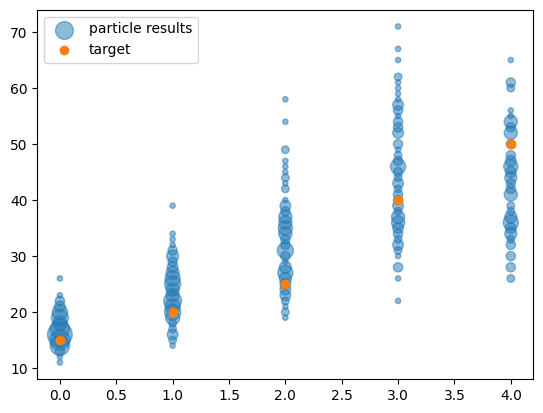

In [4]:
plot_particle_results(particles)